<a href="https://colab.research.google.com/github/Vamsi995/Covariance-Temporal-GCN-for-Traffic-Forecasting/blob/main/Graph_Attention_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/lehaifeng/T-GCN/blob/master/data/los_adj.csv

--2024-11-28 20:24:47--  https://github.com/lehaifeng/T-GCN/blob/master/data/los_adj.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘los_adj.csv’

los_adj.csv             [ <=>                ] 490.42K  --.-KB/s    in 0.04s   

2024-11-28 20:24:47 (11.6 MB/s) - ‘los_adj.csv’ saved [502187]



In [ ]:
!wget https://github.com/lehaifeng/T-GCN/blob/master/data/los_speed.csv

--2024-11-28 20:24:47--  https://github.com/lehaifeng/T-GCN/blob/master/data/los_speed.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘los_speed.csv’

los_speed.csv           [ <=>                ] 284.16K  --.-KB/s    in 0.03s   

2024-11-28 20:24:48 (9.31 MB/s) - ‘los_speed.csv’ saved [290984]



In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl

def load_sz_data(dataset):
    sz_adj = pd.read_csv(r'/content/sz_adj.csv',header=None)
    adj = np.asarray(sz_adj)
    sz_tf = pd.read_csv(r'/content/sz_speed.csv')
    return sz_tf, adj

def load_los_data():
    los_adj = pd.read_csv(r'/content/los_adj.csv',header=None)
    adj = np.asarray(los_adj)
    los_tf = pd.read_csv(r'/content/los_speed.csv')
    return los_tf, adj


def preprocess_data(data, time_len, rate, seq_len, pre_len):
    train_size = int(time_len * rate)
    train_data = data[0:train_size]
    test_data = data[train_size:time_len]

    trainX, trainY, testX, testY = [], [], [], []
    for i in range(len(train_data) - seq_len - pre_len):
        a = train_data[i: i + seq_len + pre_len]
        trainX.append(a[0 : seq_len])
        trainY.append(a[seq_len : seq_len + pre_len])
    for i in range(len(test_data) - seq_len -pre_len):
        b = test_data[i: i + seq_len + pre_len]
        testX.append(b[0 : seq_len])
        testY.append(b[seq_len : seq_len + pre_len])

    trainX1 = np.array(trainX)
    trainY1 = np.array(trainY)
    testX1 = np.array(testX)
    testY1 = np.array(testY)
    return trainX1, trainY1, testX1, testY1

In [ ]:
speed, adj = load_los_data()

In [ ]:
adj.shape

(207, 207)

In [ ]:
speed.shape

(2016, 207)

# Dataset Exploration

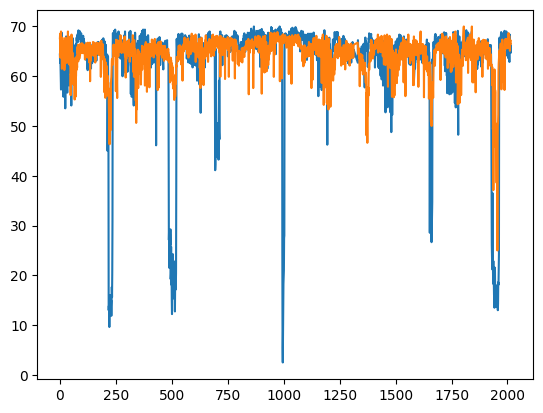

In [ ]:
from matplotlib import pyplot as plt
import numpy as np


plt.plot(speed.iloc[:, 0])

plt.plot(speed.iloc[:, 1])




In [ ]:
# new_feat = np.asarray(speed.iloc[1]).reshape((207, 1)).astype(np.float32)
features = torch.from_numpy(np.asarray(speed).astype(np.float32))

In [ ]:
# Parameters
window_length = 10  # Length of each time window
num_windows = features.shape[0] - window_length + 1  # Number of sliding windows

sliding_windows = features.unfold(0, window_length, 1).permute(0, 2, 1).unsqueeze(-1)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Functional

class STGraphSAGE(nn.Module):
    def __init__(self, input_dim, att_hidden, hidden_dim, output_dim, k, num_time_steps, num_heads):
        """
        Initialize the STGraphSAGE module.
        Args:
            input_dim: Dimension of input node features.
            hidden_dim: Dimension of hidden layers.
            output_dim: Dimension of the output embeddings.
            k: Number of spatial orders (k-hop neighbors).
            num_time_steps: Number of time steps (S).
        """
        super(STGraphSAGE, self).__init__()
        self.k = k
        self.num_time_steps = num_time_steps
        self.Ut = nn.ModuleList([nn.Linear((k + 1) * input_dim, hidden_dim) for _ in range(num_time_steps)])
        self.bt = nn.ParameterList([nn.Parameter(torch.zeros(hidden_dim)) for _ in range(num_time_steps)])
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim


        self.num_heads = num_heads

        # Linear transformations for attention mechanism
        self.U = nn.Linear(input_dim, att_hidden, bias=False)
        self.a = nn.Linear(att_hidden * 2, 1, bias=False)

        # Multi-head attention components
        self.attention_heads = nn.ModuleList([nn.Linear(input_dim, att_hidden, bias=False) for _ in range(num_heads)])


    def compute_attention(self, xi, xj):
        """
        Compute attention between two nodes xi and xj.
        Args:
            xi: Features of node i.
            xj: Features of node j.
        Returns:
            Attention score (rho_ij).
        """
        concatenated_features = torch.cat([xi, xj], dim=-1)
        return Functional.leaky_relu(self.a(concatenated_features), negative_slope=0.2)

    def dynamic_attention_weights(self, node_features, adjacency_matrix, k):
        """
        Compute the spatial weight matrix W.
        Args:
            node_features: Tensor of shape (N, F), where N is the number of nodes and F is the feature dimension.
            neighbors: List of neighbors for each node (as indices).
            k: The maximum order of neighbors.
        Returns:
            The global weight matrix W.
        """
        N, _ = node_features.shape
        adjacency_matrix = torch.from_numpy(adjacency_matrix) if not isinstance(adjacency_matrix, torch.Tensor) else adjacency_matrix

        # Transform node features
        transformed_features = self.U(node_features)

        # Initialize the global weight matrix
        W_global = torch.zeros((k, N, N), device=node_features.device)
        W_local = torch.zeros((N, N), device=node_features.device)


        # Multi-head attention (averaging results across heads)
        W_multihead = torch.zeros_like(W_global)

        for head in self.attention_heads:
            transformed_features_head = head(node_features)
            W_order = torch.zeros_like(W_local)

            for order in range(k):
              W_order = torch.zeros((N, N), device=node_features.device)

              if order != 0:
                A_k = torch.matrix_power(adjacency_matrix, order+1)
              else:
                A_k = adjacency_matrix

              # Ensure binary adjacency matrix (1 for neighbors, 0 for non-neighbors)
              A_k = (A_k > 0).float()

              # Remove self-loops
              A_k.fill_diagonal_(0)

              # Compute attention scores for k-th order neighbors
              W_order = torch.zeros((N, N), device=node_features.device)
              for i in range(N):
                  for j in range(N):
                      if A_k[i, j] > 0:  # If j is a k-th order neighbor of i
                          rho_ij = self.compute_attention(transformed_features_head[i], transformed_features_head[j])
                          W_order[i, j] = rho_ij

              W_order = Functional.softmax(W_order, dim=1)
              W_multihead[order] += W_order
              # W_multihead += W_order

        W_multihead /= self.num_heads

        return W_multihead

    def forward(self, node_features, adjacency_matrix):
        """
        Forward pass for STGraphSAGE.
        Args:
            node_features: Tensor of shape (S, N, F), where S is the number of time steps,
                           N is the number of nodes, and F is the feature dimension.
            adjacency_matrix: Tensor of shape (N, N), representing the adjacency matrix of the graph.
            W_k: List of spatial weight matrices, one for each spatial order (k-hop).
        Returns:
            Spatial-temporal embeddings of all nodes (N, output_dim).
        """
        S, N, F = node_features.size()
        aggregated_embeddings = torch.zeros((N, self.output_dim), device=node_features.device)

        for i in range(1):
            x_S_i = torch.zeros((N, self.output_dim), device=node_features.device)

            for t in range(S):
                # Step 4: Initialize hi with x(t)_i
                hi = node_features[t]

                W_k = self.dynamic_attention_weights(node_features[t], adjacency_matrix, self.k)

                for k in range(1, self.k + 1):
                    # Compute k-hop neighbors (spatial aggregation)
                    A_k = torch.matrix_power(adjacency_matrix, k)
                    A_k = (A_k > 0).float()  # Ensure binary adjacency
                    A_k.fill_diagonal_(0)  # Remove self-loops

                    # hk_i = sum_j W(k)_i,j * x(t)_j
                    hk_i = torch.sum(A_k[i, :, None] * W_k[k - 1] * node_features[t], dim=0).reshape((N, F))
                    hi = torch.cat([hi, hk_i], dim=-1)  # Concatenate hk_i to hi

                # Step 9: Compute h(t)_i
                hi_t = Functional.relu(self.Ut[t](hi) + self.bt[t])

                # Step 10: Normalize h(t)_i
                hi_t = hi_t / torch.norm(hi_t, p=2)

                # Step 11: Update x_S_i
                x_S_i += hi_t

            # Step 13: Normalize x_S_i
            x_S_i = x_S_i / torch.norm(x_S_i, p=2)
            aggregated_embeddings = x_S_i

        return aggregated_embeddings

In [ ]:


# Example usage

# Number of nodes, feature dimension, hidden dimension, and number of attention heads
num_nodes = 207
feature_dim = 1
att_hidden_dim = 8

graph_sage_hidden_dim = 8
num_heads = 2
k = 2  # Maximum order of neighbors
num_time_steps = 10  # Number of time steps (S)
output_dim = 8

# Instantiate and run the model
# model = AttentionWeightLearning(input_dim=feature_dim, hidden_dim=hidden_dim, num_heads=num_heads)
# W = model(torch.from_numpy(new_feat), adj, k)

model = STGraphSAGE(feature_dim, att_hidden_dim, graph_sage_hidden_dim, output_dim, k, num_time_steps, num_heads)
embeddings = model(sliding_windows[0], torch.from_numpy(adj))

print("Weight Matrix (W):")
print(W)


torch.Size([207, 1]) torch.Size([207, 1]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 1]) torch.Size([207, 2]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 3]) Linear(in_features=3, out_features=8, bias=True)
torch.Size([207, 1]) torch.Size([207, 1]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 1]) torch.Size([207, 2]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 3]) Linear(in_features=3, out_features=8, bias=True)
torch.Size([207, 1]) torch.Size([207, 1]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 1]) torch.Size([207, 2]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 3]) Linear(in_features=3, out_features=8, bias=True)
torch.Size([207, 1]) torch.Size([207, 1]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 1]) torch.Size([207, 2]) torch.Size([2, 207, 207]) torch.Size([207, 1])
torch.Size([207, 3]) Linear(in_features=3, out_features=8, bias=True)
torch.Si

In [ ]:
embeddings.shape

torch.Size([207, 8])

In [ ]:
!git clone https://github.com/thuml/Autoformer.git

Cloning into 'Autoformer'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 371 (delta 155), reused 143 (delta 143), pack-reused 162 (from 1)
Receiving objects: 100% (371/371), 2.20 MiB | 5.35 MiB/s, done.
Resolving deltas: 100% (219/219), done.


In [ ]:
!bash /content/Autoformer/scripts/Traffic_script/Autoformer.sh

2024-11-29:02:30:58,136 INFO     [utils.py:161] NumExpr defaulting to 2 threads.
Args in experiment:
Namespace(is_training=1, model_id='traffic_96_96', model='Autoformer', data='custom', root_path='./dataset/traffic/', data_path='traffic.csv', features='M', target='OT', freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, bucket_size=4, n_hashes=4, enc_in=862, dec_in=862, c_out=862, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=25, factor=3, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=3, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='mse', lradj='type1', use_amp=False, use_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3')
Use CPU
>>>>>>>start training : traffic_96_96_Autoformer_custom_ftM_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 12089
val 1661
test 3413
	iters: 

In [ ]:
!pip install -r /content/Autoformer/requirements.txt